## Backtesting Framework

Importing the essential libraries we have used in our framework

In [179]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In this cell, we read the dataframe generated from our strategy, it includes ohlcv data of btc-usdt, along with a column called "signals" which is either 1, -1 or 0 at each index. In this, as according to standard conditions 1 represents that we intend to long on equity, -1 representing that we intend to short on equity, and 0 representing that we intend to take no position.

In [180]:
data = pd.read_csv('data.csv') # REPLACE WITH YOUR SIGNALS FILE

In this cell, we have implemented the class "TradingStrategy", which is basically the backtesting framework.

In [181]:
class TradingStrategy:

    '''This function initializes the class according to the data provided, it creates several variables for inside the class, as described'''
    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally

        self.portfolio_value = [] # this is the portfolio value we have at each index (each day)
        self.quantity = [] # this represents the holding at each index (each day)
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (will be updated at each index)

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.01 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 0.01 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt
        self.open = data['open']

        self.candle = self.close - self.open
        self.candle_type = [1 if x > 0 else -1 if x < 0 else 0 for x in self.candle]
        self.losing_streak = []
        self.winning_streak = []

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each day
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        self.transaction_percentage = 0.0015

        self.risk_free_rate = 0.05 # you can change it

        self.amount_in_trade = []

        self.trade_wise_returns = []
        self.PL_in_dollars = []

        self.amount_invested_in_trade = []

    def create_candlestick_streak(self):
        for i in range(len(self.candle_type)):
            if i == 0 or i == 1 or i == 2:
                self.losing_streak.append(0)
            else:
                if self.candle_type[i-3] == -1 and self.candle_type[i-2] == -1 and self.candle_type[i-1] == -1 and self.candle_type[i] == -1:
                    self.losing_streak.append(1)
                else:
                    self.losing_streak.append(0)
        for i in range(len(self.candle_type)):
            if i == 0 or i == 1 or i == 2:
                self.winning_streak.append(0)
            else:
                if self.candle_type[i-3] == 1 and self.candle_type[i-2] == 1 and self.candle_type[i-1] == 1 and self.candle_type[i] == 1:
                    self.winning_streak.append(1)
                else:
                    self.winning_streak.append(0)

    '''This is the function to calculate drawdown, it returns an array of drawdown according to portolio value,
     for maximum drawdown, we will take maximum of this drawdown array'''
    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        return drawdown

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.current_position = 1
        self.holding = self.capital / self.close[i] # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
        self.portfolio_value.append(self.capital)
        self.quantity.append(0)

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.quantity.append(0)
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.quantity.append(0)
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
            elif self.losing_streak[i] == 1:
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
            elif self.winning_streak[i] == 1:
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)

    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def compounding(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        self.create_candlestick_streak()
        for i in range(x):
            self.datetime.append(self.data.datetime[i])
            if self.capital < 0: # this possibility may arise in compounding approach
                print('capital wiped')

            if self.current_position == 0:

                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''
        # we now calculate the remaining parameters like trade-wise profit/loss, max drawdown, net pnl. This is purely maths as we already have our portfolio vlaue for each day stored

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.trade_wise_profit = []
        self.trade_wise_loss = []

        for i in range(len(self.entry)):
            current_trade_return = 100*((self.portfolio_value[self.exit[i]]/self.portfolio_value[self.entry[i]])-1)
            self.PL_in_dollars.append(self.portfolio_value[self.exit[i]]-self.portfolio_value[self.entry[i]])
            self.trade_wise_returns.append(current_trade_return)
            if current_trade_return >= 0:
                self.trade_wise_profit.append(current_trade_return)
            else:
                self.trade_wise_loss.append(current_trade_return)

        self.gross_profit = np.sum(self.PL_in_dollars)
        self.calculate_transaction_cost()
        self.net_profit = self.gross_profit - self.transaction_cost
        self.returns = self.net_profit / 10
        self.drawdown = self.calculate_drawdown()
        self.calculate_ratios()
        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe() , self.create_every_day_dataframe()


    def calculate_ratios(self):
        df = pd.DataFrame()
        df['portfolio_value'] = self.portfolio_value
        df['daily_return'] = df['portfolio_value'].pct_change()
        daily_volatility = df['daily_return'].std()
        annual_volatility = daily_volatility * math.sqrt(365)
        annual_volatility_negative = df[df['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
        risk_free_rate = self.risk_free_rate
        df['excess_return'] = (df['daily_return'] - risk_free_rate)
        annual_excess_return = (df['daily_return'].mean()*365 - risk_free_rate)
        cumulative_excess_return = df['excess_return'].sum()
        negative_returns = [r for r in df['excess_return'] if r < 0]
        cumulative_volatility = df['daily_return'].std()*math.sqrt(365)
        x = np.std(negative_returns)*math.sqrt(365)
        self.sharpe_ratio = annual_excess_return / annual_volatility
        self.sortino_ratio = annual_excess_return / annual_volatility_negative

        
    def calculate_transaction_cost(self):
        self.transaction_cost = 0
        for i in range(len(self.entry)):
            self.transaction_cost += self.transaction_percentage * (self.amount_invested_in_trade[i])

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['trade type'] = self.trade_type
        trade_wise['returns'] = self.trade_wise_returns
        return trade_wise

    '''This function creates and everyday log of our strategy, to analyze the portfolio value and drawdown for each day'''
    def create_every_day_dataframe(self):
        every_day = pd.DataFrame(columns=['datetime', 'portfolio value', 'quantity'])
        every_day['datetime'] = self.datetime
        every_day['quantity'] = self.quantity
        every_day['portfolio value'] = self.portfolio_value
        every_day['daily_return'] = every_day['portfolio value'].pct_change()
        every_day['drawdown'] = self.drawdown
        return every_day

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        plt.subplot(2, 1, 1)
        plt.plot(self.portfolio_value)
        plt.title('Portfolio Value')

        plt.subplot(2, 1, 2)
        plt.plot(self.drawdown, color = 'r')
        plt.title('Drawdown')

        plt.tight_layout()

        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.trade_wise_profit))
        print('Losing trades:',len(self.trade_wise_loss))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.trade_wise_profit)/len(self.entry))*100)
        print('Maximum drawdown:',np.min(self.drawdown))
        print('Largest win:',np.max(self.trade_wise_profit))
        print('Average win:',np.mean(self.trade_wise_profit))
        print('Largest loss:',np.min(self.trade_wise_loss))
        print('Average loss:',np.mean(self.trade_wise_loss))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding period:',np.mean(self.trade_wise_duration))
        print('Gross Profit:',self.gross_profit)
        print('Net Profit:',self.net_profit)
        print('Returns:',self.returns,'%')
        print('Number of times stop loss met:',len(self.stop_loss_count))
        print('Number of times take profit met:',len(self.take_profit_count))
        print('Sharpe ratio:',self.sharpe_ratio)
        print('Sortino ratio:',self.sortino_ratio)
        print(len(self.losing_streak))

Number of closed trade: 3737
Winning trades: 2217
Losing trades: 1520
Benchmark returns: 2168.602157217745
Win rate: 59.325662295959326
Maximum drawdown: -11.0872316012804
Largest win: 8.310077892683875
Average win: 0.6103497593815282
Largest loss: -4.996489678075866
Average loss: -0.47844351410204944
Maximum holding time: 37
Average holding period: 2.64971902595665
Gross Profit: 452509.0229549997
Net Profit: 7648.895278473385
Returns: 764.8895278473385 %
Number of times stop loss met: 139
Number of times take profit met: 485
Sharpe ratio: -0.4528363259594404
Sortino ratio: -0.2553929815641202
70399


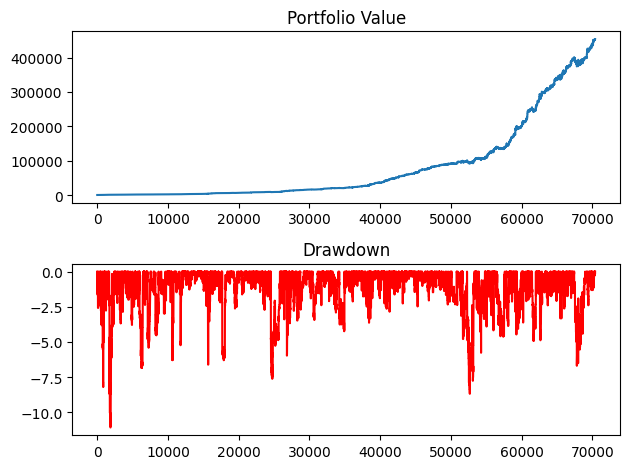

In [182]:
Testing_signals = TradingStrategy(data)
to_submit, trade_wise, every_day = Testing_signals.compounding()

In [183]:
to_submit

,datetime,open,high,low,close,volume,signals
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13521.12,221.752443,0
1,2018-01-01 06:00:00,13500.00,13690.87,13450.00,13529.01,221.603756,0
2,2018-01-01 06:30:00,13528.99,13595.89,13402.28,13560.00,160.399291,0
3,2018-01-01 07:00:00,13559.99,13559.99,13155.38,13203.06,223.297715,0
4,2018-01-01 07:30:00,13203.00,13411.76,13202.03,13225.00,203.728509,0
...,...,...,...,...,...,...,...
70394,2022-01-12 03:30:00,42664.71,42733.00,42597.41,42650.75,337.739550,0
70395,2022-01-12 04:00:00,42647.14,42776.14,42633.18,42713.13,224.120380,0
70396,2022-01-12 04:30:00,42713.12,42886.28,42665.26,42790.01,358.331130,0
70397,2022-01-12 05:00:00,42790.00,42822.21,42633.97,42729.29,322.810880,0


In [184]:
trade_wise

,entry,exit,duration,trade type,returns
0,8,9,1,long,1.273343
1,11,13,2,short,-1.633012
2,67,70,3,long,0.385073
3,83,84,1,long,4.281567
4,87,88,1,short,-2.581595
...,...,...,...,...,...
3732,70279,70280,1,short,0.404700
3733,70346,70347,1,long,-0.261781
3734,70363,70366,3,long,0.281772
3735,70373,70375,2,long,0.006458


In [185]:
every_day

,datetime,portfolio value,quantity,daily_return,drawdown
0,2018-01-01 05:30:00,1000.000000,0.0,NaN,-0.0
1,2018-01-01 06:00:00,1000.000000,0.0,0.0,-0.0
2,2018-01-01 06:30:00,1000.000000,0.0,0.0,-0.0
3,2018-01-01 07:00:00,1000.000000,0.0,0.0,-0.0
4,2018-01-01 07:30:00,1000.000000,0.0,0.0,-0.0
...,...,...,...,...,...
70394,2022-01-12 03:30:00,453509.022955,0.0,0.0,-0.0
70395,2022-01-12 04:00:00,453509.022955,0.0,0.0,-0.0
70396,2022-01-12 04:30:00,453509.022955,0.0,0.0,-0.0
70397,2022-01-12 05:00:00,453509.022955,0.0,0.0,-0.0
